**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.neighbors import KDTree

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

В свое время мне пришлось реализовать свою функцию для подсчета евклидова и косинусного расстояния, поэтому я здесь буду использовать её.

In [3]:
def euclidean_distance(X, Y):
    if len(X.shape)==1:
        X = X[np.newaxis,:]
    if len(Y.shape)==1:
        Y = Y[np.newaxis,:]
    nx, p = X.shape
    matrX = np.empty((nx, 3*p))
    matrX[:, :p] = 1
    matrX[:, p:2*p] = X
    matrX[:, 2*p:] = np.square(X)
    ny = Y.shape[0]
    matrY = np.empty((3*p, ny))
    matrY[:p] = np.square(Y).T
    matrY[p:2*p] = -2*Y.T
    matrY[2*p:] = 1
    return np.sqrt(matrX.dot(matrY))

def cosine_distance(X, Y):
    if len(X.shape)==1:
        X = X[np.newaxis,:]
    if len(Y.shape)==1:
        Y = Y[np.newaxis,:]
    U = Y.T
    v1 = X ** 2
    v1 = np.sum(v1, axis=1).reshape(-1,1)
    v2 = Y ** 2
    v2 = np.sum(v2, axis=1).reshape(1,-1)
    div = np.dot(np.sqrt(v1), np.sqrt(v2))
    ans = np.ones((len(X), len(Y))) - np.dot(X,U)/div
    return ans

In [4]:
METRICS = {
    'euclidean':euclidean_distance,
    'cosine':cosine_distance
}

In [5]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.k = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
    
    def fit(self, X, y):
        if self.algorithm=='brute':
            self.X = X
        elif self.algorithm=='kd_tree':
            self.tree = KDTree(X)
        self.y = y
    
    def predict(self, X):
        if self.algorithm=='brute':
            matr = METRICS[self.metric](X, self.X)
            ind = matr.argsort()[:,:self.k]
        elif self.algorithm=='kd_tree':
            dist, ind = self.tree.query(X, k=self.k)
            
        answmatr = np.array([self.y[i] for i in ind])
        gc = np.array([np.argmax(np.bincount(j)) for j in answmatr])
        return gc
    
    #У меня довольно долго считался cross validation, поэтому для его оптимизации была изменена 
    #логика реализации на ту, которая учитывает специфику knn и для нее требуется этот метод
    def find_kneighbours(self, X):
        if self.algorithm=='brute':
            matr = METRICS[self.metric](X, self.X)
            ind = matr.argsort()[:,:self.k]
        elif self.algorithm=='kd_tree':
            dist, ind = self.tree.query(X, k=self.k)
        return ind

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [6]:
iris = datasets.load_iris()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [8]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [9]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [10]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [11]:
%time clf.fit(X_train, y_train)

CPU times: user 629 µs, sys: 0 ns, total: 629 µs
Wall time: 638 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [12]:
%time my_clf.fit(X_train, y_train)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.06 µs


In [18]:
%time clf.predict(X_test)

CPU times: user 3.05 ms, sys: 236 µs, total: 3.28 ms
Wall time: 3.35 ms


array([2, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 1, 0, 1, 2])

In [20]:
%time my_clf.predict(X_test)

CPU times: user 472 µs, sys: 0 ns, total: 472 µs
Wall time: 1.98 ms


array([2, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 1, 0, 1, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [21]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [23]:
%time clf.fit(X_train, y_train)

CPU times: user 952 µs, sys: 767 µs, total: 1.72 ms
Wall time: 2.45 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [24]:
%time my_clf.fit(X_train, y_train)

CPU times: user 222 µs, sys: 0 ns, total: 222 µs
Wall time: 228 µs


In [25]:
%time clf.predict(X_test)

CPU times: user 3.33 ms, sys: 0 ns, total: 3.33 ms
Wall time: 6.83 ms


array([2, 0, 2, 0, 0, 1, 2, 0, 2, 2, 1, 1, 0, 2, 1])

In [26]:
%time my_clf.predict(X_test)

CPU times: user 473 µs, sys: 17 µs, total: 490 µs
Wall time: 510 µs


array([2, 0, 2, 0, 0, 1, 2, 0, 2, 2, 1, 1, 0, 2, 1])

In [27]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [8]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [9]:
data = newsgroups['data']
target = newsgroups['target']

In [10]:
type(data)

list

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
vectorizer = CountVectorizer(min_df = 0.01)
vect_data = vectorizer.fit_transform(data)

In [13]:
vect_data

<11314x1380 sparse matrix of type '<class 'numpy.int64'>'
	with 658256 stored elements in Compressed Sparse Row format>

In [14]:
def kfold(n, n_folds=3):
    ind = np.arange(n)
    siz = n//n_folds
    np.random.shuffle(ind)
    out = []
    for i in range(n_folds):
        if i == n_folds-1:
            up = n
        else:
            up = (i+1)*siz
        tmp = np.hstack((ind[:i*siz], ind[up:]))
        out.append((np.sort(tmp), np.sort(ind[i*siz:up])))
    return out

In [15]:
new = vect_data.toarray()

In [16]:
vect_data = 0

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [19]:
def find_better_neighbours(X, y, neighbours_list, **kwargs):
    res = {}
    n_folds = 3
    cv=kfold(X.shape[0], n_folds)
        
    for k in neighbours_list:
        res[k] = 0  
        
    knn = MyKNeighborsClassifier(n_neighbors=neighbours_list[-1], **kwargs)
    yset = set(y)
    for itrain, itest in cv:
        X_train, X_test = X[itrain], X[itest]
        y_train, y_test = y[itrain], y[itest]
        knn.fit(X_train, y_train)
        ind = knn.find_kneighbours(X_test)
        
        for k in neighbours_list:

            ind_k = ind[:, :k]
            answmatr = np.array([y_train[i] for i in ind_k])
            win = np.array([np.argmax(np.bincount(j)) for j in answmatr])
            scores = np.sum(y_test == win) / y_test.shape[0]
            res[k] += scores
            #print(scores)
    for i in res.keys():
        res[i] /= n_folds
    return res

In [20]:
dct = find_better_neighbours(new, target, [1,2,3,4,5,6,7,8,9,10,12,14,15,17,20, 30, 50, 100, 150], algorithm='brute')

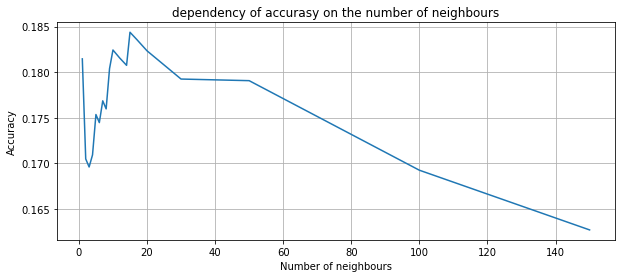

In [21]:
plt.figure(figsize=(10,4))
plt.plot(list(dct.keys()),list(dct.values()))
plt.title('dependency of accurasy on the number of neighbours')
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Можно видеть, что лучший результат достигается на 18 соседях, после чего качество падает.

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [67]:
dct_cosine = find_better_neighbours(new, target, [1,2,3,4,5,6,7,8,9,10,12,14,15,17,20, 30, 50, 100, 150], algorithm='brute', metric='cosine')

[]
[]
[]
[]
[]
[]


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
vectorizer1 = TfidfVectorizer(min_df = 0.01)
vect_data1 = vectorizer1.fit_transform(data)
new1 = vect_data1.toarray()

In [64]:
dct_tfidf_cosine = find_better_neighbours(new1, target, [1,2,3,4,5,6,7,8,9,10,12,14,15,17,20, 30, 50, 100, 150], algorithm='brute', metric='cosine')
print('ok')
dct_tfidf_eucl = find_better_neighbours(new1, target, [1,2,3,4,5,6,7,8,9,10,12,14,15,17,20, 30, 50, 100, 150], algorithm='brute', metric='euclidean')

[]
[]
[]
[]
[]
[]
ok


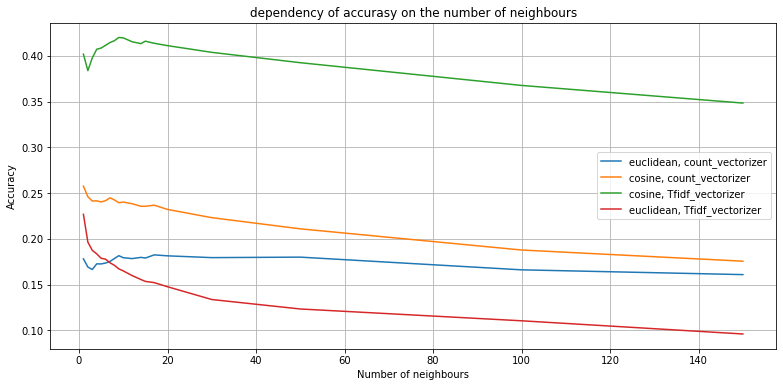

In [68]:
plt.figure(figsize=(13,6))
plt.plot(list(dct.keys()),list(dct.values()),label='euclidean, count_vectorizer')
plt.plot(list(dct_cosine.keys()),list(dct_cosine.values()),label='cosine, count_vectorizer')
plt.plot(list(dct_tfidf_cosine.keys()),list(dct_tfidf_cosine.values()),label='cosine, Tfidf_vectorizer')
plt.plot(list(dct_tfidf_eucl.keys()),list(dct_tfidf_eucl.values()),label='euclidean, Tfidf_vectorizer')
plt.title('dependency of accurasy on the number of neighbours')
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Как видно, лучше всего работает алгоритм с Tfidf при косинусой метрике на 10 соседях. Следующий по качеству это Count_vectorizer с косинусой метрикой. Хуже всего работают алгоритмы с евклидовой метрикой.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [22]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [23]:
test = newsgroups['data']
target_test = newsgroups['target']

In [28]:
vect_data2 = vectorizer1.transform(test)
new_test = vect_data2.toarray()

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [31]:
my_clf = MyKNeighborsClassifier(n_neighbors=10, algorithm='brute', metric='cosine')
my_clf.fit(new1, target)
preds = my_clf.predict(new_test)
print(np.sum(preds==target_test)/len(target_test))

0.3797132235793946


Как видно, качество на тесте чуть ниже, чем на валидации, так как во-первых, подбирали мы оптимальное количество соседей именно для валидации, а во-вторых, как и отмечалось выше, словарь для тестовой выборки может слегка отличаться от трейновского. Это тоже может сказаться на качестве.